In [1]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from align_utils import *
import cv2
import os
owd = os.getcwd()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [4]:
def raw_to_gray_uint8(rIm):
    gray_ref = downsample2x2(rIm)
    gray_ref = (gray_ref - gray_ref.min())/(gray_ref.max() - gray_ref.min()) * 255.0
    return gray_ref.astype(np.uint8)

In [5]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]
ref_idx = 0
rIm_ref = rIm[ref_idx]
#- bk_lvl
# gray_ref = raw_to_gray_uint8(rIm_ref)
alt_idx = 15
rIm_alt = rIm[alt_idx]
# - bk_lvl
# gray_alt = raw_to_gray_uint8(rIm_alt)

In [6]:
minghao_utils_path = "../Minghao/PWC_pytorch/"
sys.path.append(minghao_utils_path)
os.chdir(minghao_utils_path)
from mhutil.mh_io import cv2_imread_rgb, cv2_imwrite_rgb
from mhutil.sintel_io import flow_read, flow_write
from mhutil.image_process import backward_flow_warp, flow_to_img

inputW = 1024
inputH = 436

In [7]:
# def raw_to_stack(raw_img, pattern='rggb'):
#     """Reshape the raw image into depth 4 stack, following order rggb, depth on last channel"""
#     A,B,C,D = raw_img[:-1:2, :-1:2], \
#               raw_img[:-1:2, 1: :2], \
#               raw_img[1: :2, :-1:2], \
#               raw_img[1: :2, 1: :2]
#     if pattern.lower() == 'rggb':
#         return np.stack([A,B,C,D], axis=-1)
#     else:
#         raise NotImplementedError

# def stack_to_raw(rggb_stack):
#     H, W, _ = rggb_stack.shape
#     raw_img = np.zeros((2*H, 2*W), rggb_stack.dtype)
#     raw_img[:-1:2, :-1:2] = rggb_stack[..., 0]
#     raw_img[:-1:2, 1: :2] = rggb_stack[..., 1]
#     raw_img[1: :2, :-1:2] = rggb_stack[..., 2]
#     raw_img[1: :2, 1: :2] = rggb_stack[..., 3]
#     return raw_img

In [8]:
# preprocess and post process
def prepro(img, tgtW, tgtH):
    return cv2.resize(img, (tgtW, tgtH), None, 0, 0, cv2.INTER_AREA)
def postpro(flo, tgtW, tgtH):
    flo = np.transpose(np.array(flo), (1,2,0))
    H,W = flo.shape[:2]
    flo[:,:,0] = tgtW/W*flo[:,:,0]
    flo[:,:,1] = tgtH/H*flo[:,:,1]
    flo = cv2.resize(flo, (tgtW, tgtH), None, 0, 0, cv2.INTER_NEAREST)
    return flo

# test
def test_image_pair(img1, img2):
    imgH,imgW = img1.shape[:2]
    # preprocess
    imgin1 = prepro(img1, inputW, inputH)
    imgin2 = prepro(img2, inputW, inputH)
    # save temp image file
    cv2_imwrite_rgb("tmp/tempimg1.png", imgin1)
    cv2_imwrite_rgb("tmp/tempimg2.png", imgin2)
    # predict flow
    !python run.py --model default --first tmp/tempimg1.png --second tmp/tempimg2.png --out tmp/tempflow.flo
    # load flow back
    flowout = flow_read('tmp/tempflow.flo')
    # clean temp files
    !rm tmp/*
    # postprocess
    flow = postpro(flowout, imgW, imgH)
    # warp
    warped = backward_flow_warp(img2, flow)

    # show
    plt.figure(figsize=(16,15))
    plt.subplot(3,2,1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title("image 1 (target)")
    plt.subplot(3,2,2)
    plt.imshow(flow_to_img(flow))
    plt.axis('off')
    plt.title("flow visualization")
    plt.subplot(3,2,3)
    plt.imshow(warped)
    plt.axis('off')
    plt.title("warped")
    plt.subplot(3,2,4)
    plt.imshow(np.abs(warped.astype(np.float)-img1.astype(np.float)).astype(np.uint8))
    plt.axis('off')
    plt.title("error")
    plt.subplot(3,2,5)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("image 2 (source)")
    plt.show()
    
    return flow, warped

def test_raw_pair(img1, img2, rIm1, rIm2, display = True):
    imgH,imgW = img1.shape[:2]
    # preprocess
    imgin1 = prepro(img1, inputW, inputH)
    imgin2 = prepro(img2, inputW, inputH)
    # save temp image file
    cv2_imwrite_rgb("tmp/tempimg1.png", imgin1)
    cv2_imwrite_rgb("tmp/tempimg2.png", imgin2)
    # predict flow
    !python run.py --model default --first tmp/tempimg1.png --second tmp/tempimg2.png --out tmp/tempflow.flo
    # load flow back
    flowout = flow_read('tmp/tempflow.flo')
    # clean temp files
    !rm tmp/*
    # postprocess
    flow = postpro(flowout, imgW, imgH)
    # warp
    warped_stack = backward_flow_warp(raw_to_stack(rIm2), flow)
    warped = stack_to_raw(warped_stack)

    # show
    if display:
        plt.figure(figsize=(16,15))
        plt.subplot(3,2,1)
        plt.imshow(rIm1)
        plt.axis('off')
        plt.title("image 1 (target)")
        plt.subplot(3,2,2)
        plt.imshow(flow_to_img(flow))
        plt.axis('off')
        plt.title("flow visualization")
        plt.subplot(3,2,3)
        plt.imshow(warped)
        plt.axis('off')
        plt.title("warped")
        plt.subplot(3,2,4)
        plt.imshow(np.abs(warped.astype(np.float)-rIm1.astype(np.float)).astype(np.uint8))
        plt.axis('off')
        plt.title("error")
        plt.subplot(3,2,5)
        plt.imshow(rIm2)
        plt.axis('off')
        plt.title("image 2 (source)")
        plt.show()
    
    return flow, warped

In [9]:
def warped_raw(rIm_ref, rIm_alt, display = True):
    ## should input raw frames, 3584x2048, not-yet substract black level
    rIm_ref = rIm_ref - bk_lvl
    rIm_alt = rIm_alt - bk_lvl
    gray_ref = raw_to_gray_uint8(rIm_ref)
    gray_alt = raw_to_gray_uint8(rIm_alt)
    img1 = np.tile(gray_ref, (3, 1, 1)).transpose((1, 2, 0))
    img2 = np.tile(gray_alt, (3, 1, 1)).transpose((1, 2, 0))
    flow, warped = test_raw_pair(img1, img2, rIm_ref + bk_lvl, rIm_alt + bk_lvl, display = display)
    return warped

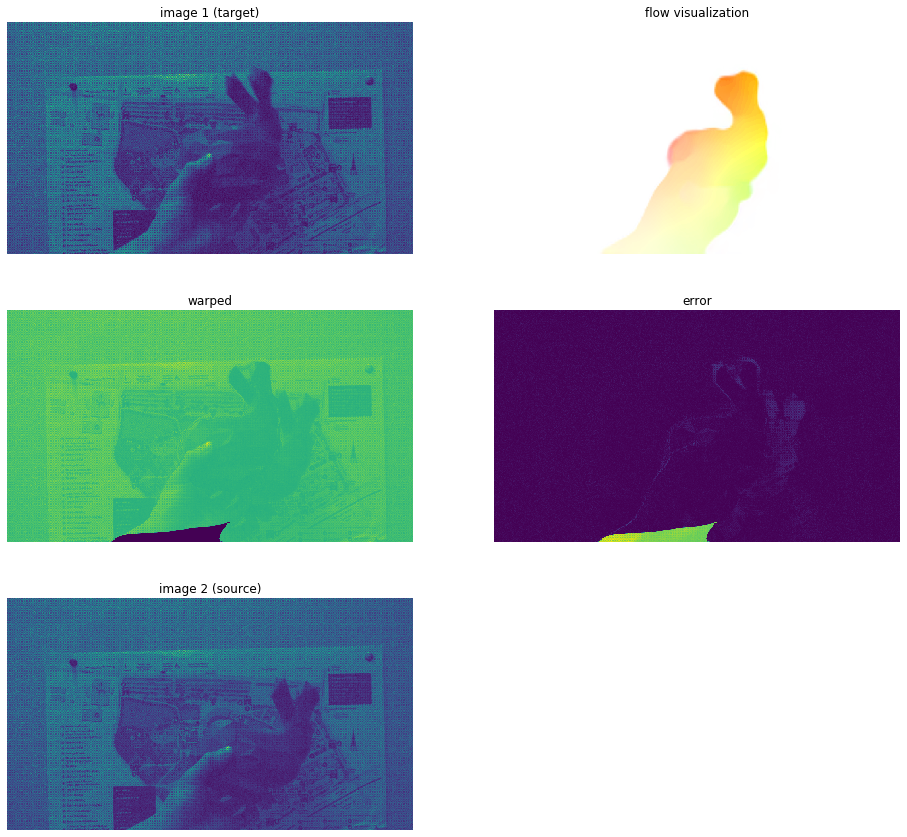

In [10]:
# img1 = np.tile(gray_ref, (3, 1, 1)).transpose((1, 2, 0))
# img2 = np.tile(gray_alt, (3, 1, 1)).transpose((1, 2, 0))
# #img1 = cv2.resize(cv2_imread_rgb('./images/first.png'),(2000,1000))
# #img2 = cv2.resize(cv2_imread_rgb('./images/second.png'),(2000,1000))
# flow, warped = test_raw_pair(img1, img2, rIm_ref + bk_lvl, rIm_alt + bk_lvl)

warped = warped_raw(rIm_ref, rIm_alt)

In [11]:
print_stat("rIm_ref", rIm_ref+ bk_lvl)
print_stat("rIm_alt", rIm_alt+ bk_lvl)
print_stat("warped", warped[warped > 0])

rIm_ref  shape:  (2048, 3584) dtype: int16
rIm_ref stat: max: 127, min: 99, mean: 106.54869651794434, std: 3.576679743798546
rIm_alt  shape:  (2048, 3584) dtype: int16
rIm_alt stat: max: 130, min: 98, mean: 106.63422284807477, std: 3.622949699712941
warped  shape:  (7246988,) dtype: int16
warped stat: max: 80, min: 2, mean: 56.38851244130665, std: 3.753840071181633


## mass warped

In [12]:
# ref_idx = 0
# rIm_ref = rIm[ref_idx] - bk_lvl
# gray_ref = raw_to_gray_uint8(rIm_ref)

# for alt_idx in range(1, 16):
#     print("generating {}th alternative warped image...".format(alt_idx))
#     rIm_alt = rIm[alt_idx] - bk_lvl
#     gray_alt = raw_to_gray_uint8(rIm_alt)
#     img1 = np.tile(gray_ref, (3, 1, 1)).transpose((1, 2, 0))
#     img2 = np.tile(gray_alt, (3, 1, 1)).transpose((1, 2, 0))
#     flow, warped = test_raw_pair(img1, img2, rIm_ref + bk_lvl, rIm_alt + bk_lvl)
#     np.save("/home/qian/Documents/HDR/flow_test/warped_npys_lowlight3_bunny3/warped_{}.npy".format(alt_idx), warped)
# #     png_warped = np.clip(warped - bk_lvl, 0, warped.max()-bk_lvl)
# #     png_warped = png_warped / png_warped.max() * 255.0
# #     cv2.imwrite("/home/qian/Documents/HDR/flow_test/png_warped_{}.png".format(alt_idx), png_warped)